In [2]:
import sys, os; sys.path.append('..')
import pyzx as zx
import random
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

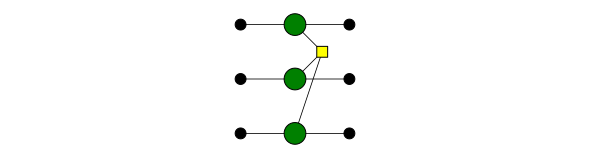

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


In [3]:
ccz = zx.qasm("""
qreg q[3];
ccz q[0],q[1],q[2];
""").to_graph(zh=True)
display(zx.draw(ccz))
print(ccz.to_matrix())

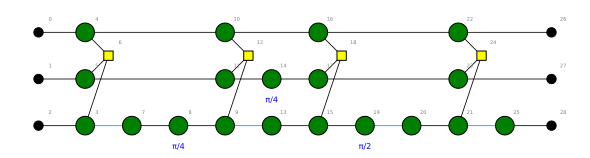

In [4]:
g = zx.qasm("""
qreg q[3];

ccz q[0],q[1],q[2];
h q[2];
t q[2];
ccz q[0],q[1],q[2];
h q[2];
t q[1];
ccz q[0],q[1],q[2];
s q[2];
ccx q[0],q[1],q[2];
""").to_graph(zh=True)
zx.draw(g, labels=True)

[(35, 20, 25, [], [28], [[4, 5], [13]], [])]


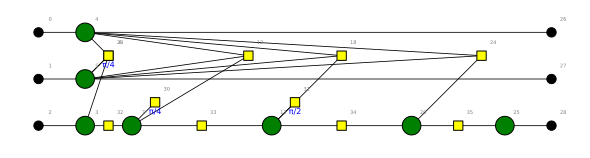

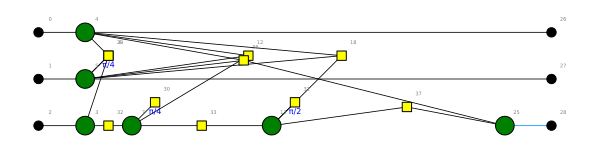

In [5]:
h = g.copy()
zx.simplify.spider_simp(h, quiet=True)
zx.hsimplify.to_hypergraph_form(h)
m = zx.hrules.match_hpivot(h)
print(m)
display(zx.draw(h,labels=True))
zx.hrules.hpivot(h,m)
display(zx.draw(h,labels=True))

spider_simp: 4. 4. 3. 1.  4 iterations
id_simp: 1.  1 iterations
hpivot: 1.  1 iterations
par_hbox: 3.  1 iterations
hpivot: 1.  1 iterations
par_hbox: 2.  1 iterations


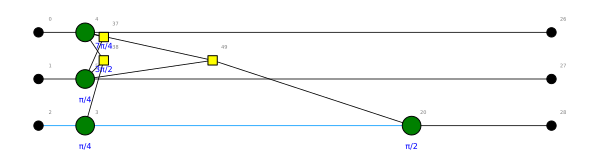

In [6]:
h = g.copy()
zx.hsimplify.hpivot_simp(h)
zx.draw(h, labels=True)

In [7]:
zx.compare_tensors(g,h)

True

In [9]:
d = os.path.join('..', 'circuits', 'benchmarking_circuits', 'Fast', 'before')
print('Circuit'.ljust(30) + '  qubits' + '   gates' + '    Z' + '       H' + '  reduced')
for f in os.listdir(d):
    f1 = os.path.join(d,f)
    if f.find('QFTAdd8') != -1: continue # takes too long
    print(f.ljust(30), end='')
    
    c = zx.Circuit.load(f1)
    for g in c.gates:
        if isinstance(g, zx.gates.ZPhase):
            g.phase = g.phase.limit_denominator(3628800)
        
    print(str(c.qubits).rjust(8), end='')
    print(str(len(c.gates)).rjust(8), end='')
    g = c.to_graph(zh=True)
    zx.hsimplify.hpivot_simp(g, quiet=True)
    g.normalize()
    z = len([v for v in g.vertices() if g.type(v) == 1])
    h = len([v for v in g.vertices() if g.type(v) == 3])
    print(str(z).rjust(5), end='')
    print(str(h).rjust(8), end='  ')
    
    print(g.qubit_count() * 2 == z)

Circuit                         qubits   gates    Z       H  reduced
tof_3                                5       9   10       2  True
tof_4                                7      15   14       3  True
csum_mux_9_corrected                30      56   60      28  True
rc_adder_6                          14      68   28     411  True
tof_5                                9      21   18       4  True
hwb6.qc                              7      79   19     144  False
mod5_4                               5      15   10       4  True
Adder8                              23     105   46      44  True
qcla_adder_10                       36     113   72      85  True
mod_mult_55                          9      35   18      13  True
qcla_com_7                          24      95   48    4117  True
QFT8                                 8     148   16      28  True
gf2^6_mult                          18     113   36      47  True
barenco_tof_4                        7      18   14       1  True
barenc